In [1]:
#Punto 1

In [2]:
import os
import pandas as pd
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
def LLamarListaDatos(ciudad,origenDatos):
    serie=os.path.join('.','data',ciudad,origenDatos+'.csv')
    serie_pd = pd.read_csv(serie, sep = ';',encoding='latin-1')
    return serie_pd

In [79]:
def ghi_mensual(serieDatos):
    agnos = sorted(serieDatos['AÑO'].unique())
    energia = list(serieDatos)[-1]
    ghidataf = pd.DataFrame(columns=["AÑO","MES","DIAS","GHImes","GHIdiarioProm"+energia])
    for agno in agnos:
        for mes in range(1,13):
            dias=sorted(serieDatos[(serieDatos['AÑO']==agno)&(serieDatos['MES']==mes)]["DIA"].unique())
            ghi_mes=serieDatos.loc[((serieDatos["AÑO"]==agno)&(serieDatos["MES"]==mes)),energia].sum()/1000
            ghi_diario = ghi_mes/dias[-1]
            ghi=dict([("AÑO",agno),("MES",mes),("DIAS",dias[-1]),("GHImes",ghi_mes),("GHIdiario",ghi_diario),("GHIdiarioProm"+energia,ghi_diario)])
            ghidataf=(ghidataf.append(ghi, ignore_index=True))
    return ghidataf


In [80]:
def enficc(serieDatos):
    percentil=0.01
    enficc=(ghi_mensual(serieDatos).quantile(q=percentil,numeric_only=True)["GHIdiarioProm"+list(serieDatos)[-1]])
    return 'La ENFICC 99% es:',enficc


In [81]:
serieDatos=LLamarListaDatos("Valledupar","IDEAM")
enficc(serieDatos)[1]

4.5690073766119133

In [82]:
#Punto 2

In [109]:
def graficas(ciudad1,ciudad2,ciudad3,ciudad4,origenDatos):
    serie1 = LLamarListaDatos(ciudad1,origenDatos)
    serie2 = LLamarListaDatos(ciudad2,origenDatos)
    serie3 = LLamarListaDatos(ciudad3,origenDatos)
    serie4 = LLamarListaDatos(ciudad4,origenDatos)
    datos1 = sorted(ghi_mensual(serie1)["GHIdiarioProm"+list(serie1)[-1]])
    datos2 = sorted(ghi_mensual(serie2)["GHIdiarioProm"+list(serie2)[-1]])
    datos3 = sorted(ghi_mensual(serie3)["GHIdiarioProm"+list(serie3)[-1]])
    datos4 = sorted(ghi_mensual(serie4)["GHIdiarioProm"+list(serie4)[-1]])
    numd1 = range(len(datos1))
    numd2 = range(len(datos2))
    numd3 = range(len(datos3))
    numd4 = range(len(datos4))
    fig=figure()
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base de Datos IDEAM")
    pylab.title(origenDatos)
    pylab.plot(numd1,datos1/datos1[0],'-k', label=ciudad1)
    pylab.plot(numd2,datos2/datos2[0],'-b', label=ciudad2)
    pylab.plot(numd3,datos3/datos3[0],'-y', label=ciudad3)
    pylab.plot(numd4,datos4/datos4[0],'-r', label=ciudad4)
    pylab.legend(loc='upper left')
    
    return 

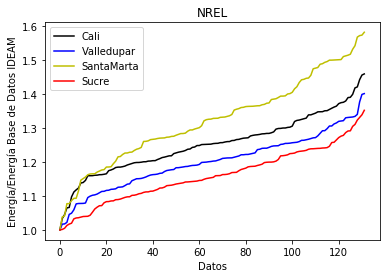

In [110]:
graficas ('Cali','Valledupar','SantaMarta','Sucre','NREL')

In [111]:
#Punto 3

In [132]:
def datosobjetivo(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    origen='IDEAM'
    seriex=LLamarListaDatos(ciudad,origen)[(LLamarListaDatos(ciudad,origen)['AÑO']>=agnoinicio)&
                                           (LLamarListaDatos(ciudad,origen)['MES']>=mesinicio)&
                                           (LLamarListaDatos(ciudad,origen)['AÑO']<=agnofinal)&
                                           (LLamarListaDatos(ciudad,origen)['MES']<=mesfinal)]
    return seriex

def datosreferencia (agnoinicio, mesinicio,agnofinal,mesfinal,ciudad):
    origen='NREL'
    seriey=LLamarListaDatos(ciudad,origen)[(LLamarListaDatos(ciudad,origen)['AÑO']>=agnoinicio)&
                                           (LLamarListaDatos(ciudad,origen)['MES']>=mesinicio)&
                                           (LLamarListaDatos(ciudad,origen)['AÑO']<=agnofinal)&
                                           (LLamarListaDatos(ciudad,origen)['MES']<=mesfinal)]
    return seriey

def funcionmcp (agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    ref_origen='NREL'
    obj_origen='IDEAM'
    ref=datosreferencia (agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[ref_origen]
    obj=datosobjetivo (agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[obj_origen]
    GHIref=ref.sum()/count_nonzero(ref)
    GHIobj=obj.sum()/count_nonzero(obj)
    DSTDref=ref[ref!=0].std()
    DSTDobj=obj[obj!=0].std()
    relDSTDs=DSTDobj/DSTDref
   
    refL=LLamarListaDatos(ciudad,ref_origen)[ref_origen]
    VA=GHIobj-(relDSTDs*GHIref)
    VB=relDSTDs*refL
    dataframe=LLamarListaDatos(ciudad,ref_origen)
    dataframe['IDEAM']=LLamarListaDatos(ciudad,obj_origen)[obj_origen]
    dataframe['MCP']=VA+VB
    return dataframe

def seriecorta(serie,agnoinicio,agnofinal):
    sc=serie[(serie['AÑO']>=agnoinicio)&(serie['AÑO']<=agnofinal)]
    return sc

def graficaciudad(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    med_origen='IDEAM'
    ref_origen='NREL'
    mcpd= ghi_mensual(funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad))['ghi_mensual']
    NREL= ghi_mensual(llamarListaDatos(ciudad,ref_origen))['ghi_mensual']
    IDEAM = ghi_mensual(llamarListaDatos(ciudad,rmed_origen))['ghi_mensual']
    fig=figure()
    pylab.xlabel('Meses')
    pylab.ylabel(r'$GHI[\frac{W}{m^2}]$')
    pylab.plot(range(len(NREL)),NREL,'-k', label='Datos Satelitales')
    pylab.plot(range(len(IDEAM)),IDEAM,'-b', label='Datos Medidos')
    pylab.plot(range(len(mcpd)),MCPData,'-r', label='Datos Corregidos')
    pylab.legend(loc='upper left')
    fig1=figure()
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía de Base")
    mcpd2=sorted(mcpd)
    NREL2=sorted(NREL)
    IDEAM2=sorted(IDEAM)
    pylab.xlabel('Datos')
    pylab.ylabel(r'$GHI/GHI[\frac{W}{m^2}]/[\frac{W}{m^2}]$')
    pylab.plot(range(len(NREL2)),NREL2/NREL2[0],'-k', label='Datos Satelitales')
    pylab.plot(range(len(IDEAM)),IDEAM2/IDEAM2[0],'-b', label='Datos Medidos')
    pylab.plot(range(len(mcpd)),mcpd2/mcpd2[0],'-r', label='Datos Corregidos')
    pylab.legend(loc='upper left')
    return fig1

In [133]:
graficaciudad(2011,1,2016,12,'Cali')

KeyError: 'ghi_mensual'

In [ ]:
#Punto 4

In [ ]:
def funcionrms(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    MCP_rms='MCP'
    NREL_rms='NREL'
    obj_rms='IDEAM'
    
    MCP_x=funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[MCP_rms]
    NREL_x=funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[NREL_rms]
    obj_x=funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[obj_rms]
           
    RMS_mcp_insum=(obj_x-MCP_x)**2
    RMS_nrel_insum=(obj_x-NREL_x)**2
    
    RMS_MCP=((RMS_mcp_insum.sum()/len(RMS_mcp_insum))**0.5)/(obj_x.max()-obj_x.min())
    RMS_NREL=((RMS_nrel_insum.sum()/len(RMS_nrel_insum))**0.5)/(obj_x.max()-obj_x.min())
    
    dataframerms=pd.DataFrame({'RMS':[0,RMS_NREL,RMS_MCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return dataframerms

def funcionmbe(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    MCP_mbe='MCP'
    NREL_mbe='NREL'
    obj_mbe='IDEAM'
    #
    MCP_x=funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[MCP_mbe]
    NREL_x=funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[NREL_mbe]
    obj_x=funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)[obj_mbe]
    #
    Error_MBE_MCP=( MCP_x-obj_x).sum()/(obj_x.sum())
    Error_MBE_NREL=(NREL_x-obj_x).sum()/(obj_x.sum())
    #
    dataframe_mbe=pd.DataFrame({'MBE':[0,Error_MBE_NREL,Error_MBE_MCP]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return dataframe_mbe


def funcionksi(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    agno_1=LLamarListaDatos(ciudad,'IDEAM')['AÑO'].min()
    agno_2=LLamarListaDatos(ciudad,'IDEAM')['AÑO'].max()    
    NREL=seriecorta(LLamarListaDatos(ciudad,'NREL'),agno_1,agno_2)['NREL']
    D_MCP=seriecorta(funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad),agno_1,agno2)['MCP']
    
    IDEAM=LLamarListaDatos(ciudad,'IDEAM')['IDEAM']    
    Error_NREL=stats.ks_2samp(NREL,IDEAM)
    Error_MCP=stats.ks_2samp(D_MCP,IDEAM)
    dataframeksi=pd.DataFrame({'D':[0,Error_NREL[0],Error_MCP[0]],'p-Value':[1,Error_NREL[1],Error_MCP[1]]},index=['ideal','NREL vs IDEAM','MCP vs IDEAM'])
    return dataframeksi

def errores(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    df_error=funcionrms(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)
    df_error['MBE']=funcionmbe(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)['MBE']
    df_error['KS statistic']=funcionksi(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)['D']
    df_error['p-Value']=funcionksi(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad)['p-Value']
    return df_error
def enficcs(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad):
    e_IDEAM=enficc(LLamarListaDatos(ciudad,'IDEAM'))
    e_NREL=enficc(LLamarListaDatos(ciudad,'NREL'))
    e_MCP=enficc(funcionmcp(agnoinicio,mesinicio,agnofinal,mesfinal,ciudad))
    dataframe_enficc=pd.DataFrame({'IDEAM':[e_IDEAM[1]],'NREL':[e_NREL[1]],'MCP':[e_MCP[1]]},index=['ENFICC'])
    return dataframe_enficc

errores(2007,1,2015,1,"Cali")
enficcs(2007,1,2015,1,"Cali")

In [ ]:
#punto 5